In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
polls = pd.read_csv("polls_for_2023.csv")
polls_2018 = pd.read_csv("polls_2018.csv")

In [3]:
print(polls_2018.head())

       Yapılış tarihi    Anketi yapan Örneklem    AKP    CHP    İYİ    HDP  \
0       18-22 Haziran         Piar[1]     2464     37   23.4   15.7   14.1   
1          12 Haziran       Mediar[5]     2401  41.51  26.27  10.73  12.12   
2  28 Mayıs-3 Haziran  REMRES[6][n 1]     4482     40   23.6   15.2   10.4   
3            31 Mayıs         Piar[7]     3500   34.8   23.4   17.2   14.1   
4          1-28 Mayıs    Konsensus[8]     2000   43.7   27.4   11.3    9.7   

    MHP    SP Diğer   Yıl  
0   6.5     3   0.3  2018  
1  5.81  2.25  1.31  2018  
2   5.1   4.2   1.5  2018  
3   7.3   2.5   0.7  2018  
4   7.4   0.3   0.2  2018  


In [4]:
polls_2018.drop(polls_2018.columns[[0,1]], axis=1, inplace=True)
polls_2018.head(), polls_2018.columns

(  Örneklem    AKP    CHP    İYİ    HDP   MHP    SP Diğer   Yıl
 0     2464     37   23.4   15.7   14.1   6.5     3   0.3  2018
 1     2401  41.51  26.27  10.73  12.12  5.81  2.25  1.31  2018
 2     4482     40   23.6   15.2   10.4   5.1   4.2   1.5  2018
 3     3500   34.8   23.4   17.2   14.1   7.3   2.5   0.7  2018
 4     2000   43.7   27.4   11.3    9.7   7.4   0.3   0.2  2018,
 Index(['Örneklem', 'AKP', 'CHP', 'İYİ', 'HDP', 'MHP', 'SP', 'Diğer', 'Yıl'], dtype='object'))

In [5]:
for column in polls_2018.columns[:-1]:
    polls_2018[column] = polls_2018[column].str.replace("+", "").str.replace(",", ".").astype(float)
polls_2018.head()

C:\Users\bumin\AppData\Local\Temp/ipykernel_20888/2476538830.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  polls_2018[column] = polls_2018[column].str.replace("+", "").str.replace(",", ".").astype(float)


,Örneklem,AKP,CHP,İYİ,HDP,MHP,SP,Diğer,Yıl
0,2464.0,37.00,23.40,15.70,14.10,6.50,3.00,0.30,2018
1,2401.0,41.51,26.27,10.73,12.12,5.81,2.25,1.31,2018
2,4482.0,40.00,23.60,15.20,10.40,5.10,4.20,1.50,2018
3,3500.0,34.80,23.40,17.20,14.10,7.30,2.50,0.70,2018
4,2000.0,43.70,27.40,11.30,9.70,7.40,0.30,0.20,2018


In [6]:
def calculate_weight(row, prev_participants=50_000_000, threshold=1.5, max_weight=1.5):
    # Get the current year
    current_year = dt.datetime.now().year
    
    # Calculate the weight based on the difference between the year of the datapoint and the current year
    year_diff = current_year - row["Yıl"]
    
    # Decrease the weight for every datapoint
    weight = 0.99 - row.name * 0.001
    
    # Increase the speed of decrease when the year changes
    if row.name != 0 and row["Yıl"] != polls_2018.iloc[row.name - 1]["Yıl"]:
        year_diff -= 1
        weight = 0.80
    
    # Apply an exponential decay function to the weight based on the year difference
    weight = weight ** year_diff
    
    # Multiply the weight by a factor that increases as the number of participants increases
    weight *= row["Örneklem"] / polls_2018["Örneklem"].mean()
    
    # Add a term that adjusts the weight based on the ratio of the number of participants in the current poll to the previous election
    ratio = row["Örneklem"] / prev_participants
    if ratio > threshold:
        ratio = threshold
    if ratio > 1:
        weight *= np.log10(ratio) * 0.3 + 1
    else:
        weight *= np.log10(1/ratio) * 0.3 + 1
    
    # Cap the weight adjustment term at a maximum value
    if weight > max_weight:
        weight = max_weight
    
    return weight

# Apply the calculate_weight function to the index of the DataFrame to calculate the weight of each datapoint
#polls["weight"] = polls.index.map(calculate_weight)
prev_participants = 47239370
# Replace with the number of participants in the previous election

polls_2018["weight"] = polls_2018.apply(calculate_weight, args=(prev_participants,), axis=1)

polls_2018["weight"] = polls_2018["weight"].astype(float)



In [7]:
weighted_avg_polls_2018 = pd.DataFrame(index=["weighted_avg"])
for party in polls_2018.columns[:]:
    # Exclude rows with missing values or zero values for the current party column
    valid_rows = (polls_2018[party].notnull()) & (polls_2018[party] != 0)
    # Calculate the weighted average for the valid rows only
    if valid_rows.any():
        weighted_avg = (polls_2018.loc[valid_rows, party] * polls_2018.loc[valid_rows, "weight"]).sum() / polls_2018.loc[valid_rows, "weight"].sum()
    else:
        # Calculate the average value of the party column across all rows
        avg_value = polls_2018[party].mean()
        # Calculate the average weight of rows where the party column has a value
        avg_weight = polls_2018.loc[polls_2018[party].notnull(), "weight"].mean()
        # Calculate the half-weighted average for the missing rows
        weighted_avg = 0.5 * (avg_value + (avg_weight * weighted_avg_polls_2018.loc["weighted_avg", party]))
    weighted_avg_polls_2018.loc["weighted_avg", party] = weighted_avg


In [8]:
selected_columns = weighted_avg_polls_2018.columns[1:-2]

sum_weighted_avg = weighted_avg_polls_2018[selected_columns].iloc[0].sum()

# Normalize the weighted averages to add up to 100
weighted_avg_polls_2018.iloc[0] = weighted_avg_polls_2018.iloc[0] * 100 / sum_weighted_avg

In [9]:
weighted_avg_polls_2018

,Örneklem,AKP,CHP,İYİ,HDP,MHP,SP,Diğer,Yıl,weight
weighted_avg,31352.550354,42.053068,22.231878,13.079372,9.105944,8.91652,2.416083,2.197135,1859.456752,0.673076


In [10]:
print(polls.head())
polls.columns

  Anketin Tarihi      Anket Şirketi Örneklem   AKP   CHP  BBP  YRP  MHP   IYI  \
0      13/5/2023            Özdemir     3016  38,3  23,8    0    0  7,9  10,0   
1      12/5/2023            BETİMAR     5751  38,7  23,8  0,4  1,6  7,8  10,2   
2      12/5/2023  Areda Survey[a 1]    25000  41,4  26,0  0,4  1,6  8,9   7,5   
3      12/5/2023         Aksoy[a 2]     4000  37,2  30,5    0  1,2  6,9   9,1   
4      11/5/2023                ORC     3920  34,5  28,4    0    0  7,3  13,7   

  DEVA GP SP DP   YSP  TIP   ZP   MP TDP BTP Diger  
0    0  0  0  0  11,1  1,9  2,0  2,2   0   0   2,8  
1    0  0  0  0  11,0  1,8  2,1  2,1   0   0   0,5  
2    0  0  0  0   9,2  1,5  1,9  1,1   0   0   0,5  
3    0  0  0  0   8,2  2,0  2,8  1,2   0   0   0,9  
4    0  0  0  0  10,6    0    0    0   0   0   5,5  


Index(['Anketin Tarihi', 'Anket Şirketi', 'Örneklem', 'AKP', 'CHP', 'BBP',
       'YRP', 'MHP', 'IYI', 'DEVA', 'GP', 'SP', 'DP', 'YSP', 'TIP', 'ZP', 'MP',
       'TDP', 'BTP', 'Diger'],
      dtype='object')

In [11]:
polls.drop(polls.columns[1], axis=1, inplace=True)
polls.head(), polls.columns

(  Anketin Tarihi Örneklem   AKP   CHP  BBP  YRP  MHP   IYI DEVA GP SP DP  \
 0      13/5/2023     3016  38,3  23,8    0    0  7,9  10,0    0  0  0  0   
 1      12/5/2023     5751  38,7  23,8  0,4  1,6  7,8  10,2    0  0  0  0   
 2      12/5/2023    25000  41,4  26,0  0,4  1,6  8,9   7,5    0  0  0  0   
 3      12/5/2023     4000  37,2  30,5    0  1,2  6,9   9,1    0  0  0  0   
 4      11/5/2023     3920  34,5  28,4    0    0  7,3  13,7    0  0  0  0   
 
     YSP  TIP   ZP   MP TDP BTP Diger  
 0  11,1  1,9  2,0  2,2   0   0   2,8  
 1  11,0  1,8  2,1  2,1   0   0   0,5  
 2   9,2  1,5  1,9  1,1   0   0   0,5  
 3   8,2  2,0  2,8  1,2   0   0   0,9  
 4  10,6    0    0    0   0   0   5,5  ,
 Index(['Anketin Tarihi', 'Örneklem', 'AKP', 'CHP', 'BBP', 'YRP', 'MHP', 'IYI',
        'DEVA', 'GP', 'SP', 'DP', 'YSP', 'TIP', 'ZP', 'MP', 'TDP', 'BTP',
        'Diger'],
       dtype='object'))

In [12]:
for column in polls.columns[1:-1]:
    polls[column] = polls[column].str.replace("+", "").str.replace(",", ".").astype(float)
polls.head()

C:\Users\bumin\AppData\Local\Temp/ipykernel_20888/3519772975.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  polls[column] = polls[column].str.replace("+", "").str.replace(",", ".").astype(float)


,Anketin Tarihi,Örneklem,AKP,CHP,BBP,YRP,MHP,IYI,DEVA,GP,SP,DP,YSP,TIP,ZP,MP,TDP,BTP,Diger
0,13/5/2023,3016.0,38.3,23.8,0.0,0.0,7.9,10.0,0.0,0.0,0.0,0.0,11.1,1.9,2.0,2.2,0.0,0.0,"2,8"
1,12/5/2023,5751.0,38.7,23.8,0.4,1.6,7.8,10.2,0.0,0.0,0.0,0.0,11.0,1.8,2.1,2.1,0.0,0.0,"0,5"
2,12/5/2023,25000.0,41.4,26.0,0.4,1.6,8.9,7.5,0.0,0.0,0.0,0.0,9.2,1.5,1.9,1.1,0.0,0.0,"0,5"
3,12/5/2023,4000.0,37.2,30.5,0.0,1.2,6.9,9.1,0.0,0.0,0.0,0.0,8.2,2.0,2.8,1.2,0.0,0.0,"0,9"
4,11/5/2023,3920.0,34.5,28.4,0.0,0.0,7.3,13.7,0.0,0.0,0.0,0.0,10.6,0.0,0.0,0.0,0.0,0.0,"5,5"


In [13]:
# Add up the values in the DEVA, GP, SP, and DP columns and assign the results to the CHP column
polls["CHP"] = polls[["CHP","DEVA", "GP", "SP", "DP", "BTP", "TDP"]].sum(axis=1)

polls.drop(["DEVA","GP","SP","DP", "BTP", "TDP", "Diger"],axis=1,inplace=True)

In [14]:
polls["Anketin Tarihi"] = pd.to_datetime(polls["Anketin Tarihi"], format="%d/%m/%Y")

In [15]:
def calculate_weight(row, prev_participants=50_000_000, max_weight=1.5):
    # Get the current year and month
    current_year = dt.datetime.now().year
    current_month = dt.datetime.now().month
    
    # Extract the year and month from the date in the "Anketin Tarihi" column
    year = int(row["Anketin Tarihi"].strftime("%Y"))
    month = int(row["Anketin Tarihi"].strftime("%m"))
    
    # Calculate the weight based on the difference between the year and month of the datapoint and the current year and month
    year_diff = current_year - year
    month_diff = current_month - month
    
    # Calculate the base weight
    weight = 0.99 - row.name * 0.001
    
    # Increase the speed of decrease when the year and month changes
    if row.name != 0 and (year != int(polls.iloc[row.name - 1]["Anketin Tarihi"].strftime("%Y")) or month != int(polls.iloc[row.name - 1]["Anketin Tarihi"].strftime("%m"))):
        if year_diff > 0 or (year_diff == 0 and month_diff > 0):
            year_diff -= 1
            weight = 0.90
    
    # Apply an exponential decay function to the weight based on the year difference
    weight = weight ** year_diff
    
    # Multiply the weight by a factor that increases as the number of participants increases
    weight *= row["Örneklem"] / polls["Örneklem"].mean()
    
    # Add a term that adjusts the weight based on the ratio of the number of participants in the current poll to the previous election
    if prev_participants > 0:
        ratio = row["Örneklem"] / prev_participants
        if ratio > 1:
            weight *= np.log10(ratio) * 0.3 + 1
        else:
            weight *= np.log10(1/ratio) * 0.3 + 1
    
    # Cap the weight adjustment term at a maximum value
    if weight > max_weight:
        weight = max_weight
    
    return weight

# Apply the calculate_weight function to the index of the DataFrame to calculate the weight of each datapoint
#polls["weight"] = polls.index.map(calculate_weight)
prev_participants = 50137175  # Replace with the number of participants in the previous election

polls["weight"] = polls.apply(calculate_weight, args=(prev_participants,), axis=1)

polls["weight"] = polls["weight"].astype(float)

In [16]:
weighted_avg_polls = pd.DataFrame(index=["weighted_avg"])
for party in polls.columns[1:]:
    # Exclude rows with missing values or zero values for the current party column
    valid_rows = (polls[party].notnull()) & (polls[party] != 0)
    # Calculate the weighted total and sum of weights for the valid rows only
    weighted_total = (polls.loc[valid_rows, party] * polls.loc[valid_rows, "weight"]).sum()
    sum_weighted_totals = polls.loc[valid_rows, "weight"].sum()
    # Calculate the weighted average for the valid rows only, or set it to zero if the sum of weights is zero
    weighted_avg = (weighted_total / sum_weighted_totals) if sum_weighted_totals != 0 else 0
    # Add the weighted average to the DataFrame
    weighted_avg_polls.loc["weighted_avg", party] = weighted_avg

In [17]:
selected_columns = weighted_avg_polls.columns[1:-2]

sum_weighted_avg = weighted_avg_polls[selected_columns].iloc[0].sum()

# Normalize the weighted averages to add up to 100
weighted_avg_polls.iloc[0] = weighted_avg_polls.iloc[0] * 100 / sum_weighted_avg

In [18]:
weighted_avg_polls

,Örneklem,AKP,CHP,BBP,YRP,MHP,IYI,YSP,TIP,ZP,MP,weight
weighted_avg,1.006390e+07,35.651395,30.084261,0.151544,1.191011,8.098776,12.193467,9.681002,1.430683,1.517861,1.172365,0.359342


In [19]:
#Rename the columns to be consistent
polls = polls.rename(columns={"AKP": "akp", "CHP": "chp", "BBP": "bbp", "YRP": "yrp",
                              "MHP": "mhp", "IYI": "iyi", "YSP": "ysp", "TIP": "tip", "ZP": "zp", "MP": "mp",
                              "Örneklem": "sample_size", "Anketin Tarihi": "date"})


# Aggregate the poll data by date and compute the mean values
polls_agg = polls.groupby("date").mean().reset_index()

# Print the resulting data frame
print(polls_agg)

          date   sample_size    akp        chp       bbp       yrp        mhp  \
0   2018-06-24  5.013718e+07  42.56  23.990000  0.100000  0.000000  11.100000   
1   2019-01-12  9.281000e+03  35.90  28.900000  0.100000  0.000000  11.000000   
2   2019-01-15  2.000000e+03  37.10  25.200000  0.100000  0.000000  11.600000   
3   2019-01-19  9.298000e+03  35.00  25.900000  0.100000  0.000000  13.600000   
4   2019-03-01  2.523000e+03  45.50  30.000000  0.100000  0.000000   7.600000   
..         ...           ...    ...        ...       ...       ...        ...   
253 2023-05-08  3.210000e+03  37.40  31.200000  0.200000  0.650000   7.000000   
254 2023-05-09  5.125000e+03  37.15  28.675000  0.050000  0.875000   8.300000   
255 2023-05-11  3.727167e+03  37.00  29.016667  0.183333  0.683333   7.516667   
256 2023-05-12  1.158367e+04  39.10  26.766667  0.266667  1.466667   7.866667   
257 2023-05-13  3.016000e+03  38.30  23.800000  0.000000  0.000000   7.900000   

           iyi        ysp  

In [20]:
party_names = ['akp', 'chp', 'bbp', 'yrp', 'mhp', 'iyi', 'tip', 'ysp', 'zp', 'mp']

# Step 3: Calculate weighted mean of poll results for each party
party_means = {}
for party in party_names:
    party_means[party] = (polls[party] * polls["weight"]).sum() / polls["weight"].sum()


# Step 4: Print predicted vote percentages for each party
for party, percentage in party_means.items():
    print(party + ":", "{:2%}".format(percentage/100))


akp: 35.499762%
chp: 29.956307%
bbp: 0.142041%
yrp: 0.498800%
mhp: 8.064331%
iyi: 12.141605%
tip: 0.345818%
ysp: 9.639826%
zp: 0.603295%
mp: 0.623663%


In [21]:
# Set the date column as the index
polls = polls.set_index("date")
polls.sort_index(ascending=False,inplace=True)

In [22]:
polls.head(20)

,sample_size,akp,chp,bbp,yrp,mhp,iyi,ysp,tip,zp,mp,weight
date,,,,,,,,,,,,
2023-05-13,3016.0,38.3,23.8,0.0,0.0,7.9,10.0,11.1,1.9,2.0,2.2,0.034459
2023-05-12,4000.0,37.2,30.5,0.0,1.2,6.9,9.1,8.2,2.0,2.8,1.2,0.044960
2023-05-12,5751.0,38.7,23.8,0.4,1.6,7.8,10.2,11.0,1.8,2.1,2.1,0.063269
2023-05-12,25000.0,41.4,26.0,0.4,1.6,8.9,7.5,9.2,1.5,1.9,1.1,0.250903
2023-05-11,3920.0,34.5,28.4,0.0,0.0,7.3,13.7,10.6,0.0,0.0,0.0,0.044112
2023-05-11,5950.0,38.0,27.7,1.0,1.3,8.7,8.4,8.1,2.6,1.2,2.5,0.065325
2023-05-11,2476.0,35.5,30.4,0.0,1.1,7.8,9.6,10.2,2.6,1.6,0.0,0.028610
2023-05-11,2038.0,40.3,30.5,0.0,0.0,5.2,8.6,10.1,1.6,0.0,1.1,0.023810
2023-05-11,2568.0,38.8,26.7,0.0,1.1,8.8,9.1,10.2,1.3,0.0,1.6,0.029612


In [23]:
# Convert start and stop dates to integer values
start_date = int(polls.index[0].timestamp())
stop_date = int(polls.index[-1].timestamp())

# Calculate the time difference between the first and last date in seconds
time_diff = (stop_date - start_date) // (24*3600)

# Calculate the number of steps you want to interpolate between the first and last date
num_steps = len(polls)

# Create an array of the desired time steps, evenly spaced between the first and last date
new_dates = pd.date_range(start=polls.index[0], end=polls.index[-1], periods=num_steps)

# Create a new index for the dataframe with the new dates
polls.set_index(new_dates, inplace=True)


In [24]:
# Convert the percentages to decimal values
polls[party_names] = polls[party_names] 

# Compute the moving average of the percentages for each party
window_size = 10 # you can adjust this as needed


ma_data = polls[party_names].rolling(window_size).mean()


filtered_data = ma_data[ma_data >= 0.001]



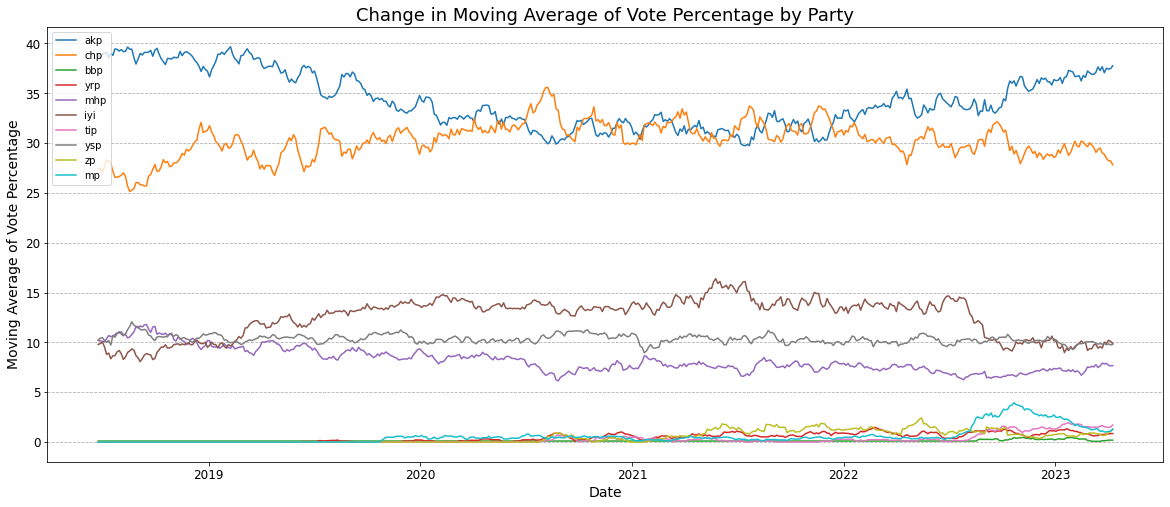

Last moving average for polling data:
akp    38.906
chp    27.399
bbp     0.100
yrp       NaN
mhp    10.200
iyi     9.796
tip       NaN
ysp    10.240
zp        NaN
mp        NaN
Name: 2018-06-24 00:00:00, dtype: float64


In [25]:
# Plot the moving average data
plt.figure(figsize=(20, 8)) # adjust the size of the plot as needed
plt.plot(ma_data)
plt.legend(party_names, loc="upper left") # move the legend to the upper left corner
plt.xlabel("Date", fontsize=14) # increase the font size of the x-axis label
plt.ylabel("Moving Average of Vote Percentage", fontsize=14) # increase the font size of the y-axis label
plt.title("Change in Moving Average of Vote Percentage by Party", fontsize=18) # add a title to the plot
plt.grid(True, axis="y", linestyle="--") # add horizontal grid lines
plt.tick_params(labelsize=12) # increase the font size of the tick labels


plt.show()

# Print the last moving average for both the polling and GDP data
print("Last moving average for polling data:")
print(filtered_data.iloc[-1])
